# Neural Net model 2
Include all features from feature set and use some logic to select only most promising features.


- V0: HyperOpt NN with one layer
    - Minimum achieved around 15 epochs (test with that)

Scores:
- V0: CV: 2.2397, LB: 2.2441

In [131]:

import os
import random
import time
import sys
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#import sys
#import pymongo
#import bson.objectid
#pymongo.objectid = bson.objectid
#sys.modules["pymongo.objectid"] = bson.objectid

#os.environ['KERAS_BACKEND']='tensorflow'
#os.environ['THEANO_FLAGS'] = 'device=cpu'
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.callbacks import Callback
import keras

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.sparse import csr_matrix, hstack
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import log_loss

from ml_toolbox.kaggle import KaggleResult

%matplotlib inline


In [132]:
dir_in = 'data_ori'
dir_feat = 'data'
sub_dir = 'model_2_nn'

In [133]:
rs = 123
np.random.seed(rs)
random.seed(rs) # not sure if needed or not


feature_files = ['features_brand_model_bag',
                 'features_brand_bag',
                 'features_appid_installed',
                 'features_label_app_installed',
                 'features_events_totals.csv',
                 'features_appid_totals.csv',
                 'features_label_app_count.csv',
                 'features_group_app_count.csv',
                 'features_geo.csv',
                 'features_events_per_day.csv',
                 'features_events_per_hour_grouped.csv',
                 'features_brand_model.csv',
                 'features_group_app_installed_prop.csv',
                 'features_group_app_active_count.csv',
                 'features_group_app_active_prop.csv',
                 'features_group_app_active_rel.csv']

feat_filter = {'features_events_totals.csv': ['n_events']}

feature_files = ['features_brand_model_bag',
                 'features_brand_bag',
                 'features_appid_installed',
                 'features_label_app_installed',
                 'features_appid_installed_active',
                 'features_events_totals.csv']

# Function to read feature file
def open_feature_file(fname, samples='train', output='csr', f_filter=[]):
    if fname[-3:] == 'csv':
        if samples=='train':
            X = gatrain[['device_id']].merge( pd.read_csv(os.path.join(dir_feat, fname)), on='device_id', how='left')
        else:
            X = gatest[['device_id']].merge( pd.read_csv(os.path.join(dir_feat, fname)), on='device_id', how='left')
        
        if fname in f_filter:
            X = X[f_filter[fname]]
            print('{} from {}'.format(X.shape, fname))
        else:
            X.drop('device_id', axis=1, inplace=True)
        X.fillna(0, inplace=True)
        
        for c in X.columns:
            if X[c].max()>1:
                X[c] = StandardScaler().fit_transform(X)
        
        if output == 'csr':
            return csr_matrix(X.values)
        else:
            return X
    else:
        # Assume it is a pickle file
        with open(os.path.join(dir_feat, '{}_{}.pickle'.format(fname,samples)), 'rb') as f:
            return pickle.load(f)

## Load train/test data

In [134]:
gatrain = pd.read_csv(os.path.join(dir_in,'gender_age_train.csv'))
gatest = pd.read_csv(os.path.join(dir_in,'gender_age_test.csv'))
targetencoder = LabelEncoder().fit(gatrain.group)
y = targetencoder.transform(gatrain.group)
nclasses = len(targetencoder.classes_)
dummy_y = np_utils.to_categorical(y)

In [135]:
fw = [1, 1, 1, 1]
Xtrain = hstack([open_feature_file(f, f_filter=feat_filter) for f in feature_files],format='csr')
Xtest = hstack([open_feature_file(f,'test', f_filter=feat_filter) for f in feature_files],format='csr')

print('Train on {} features'.format(Xtrain.shape[1]))
print('Test on {} features'.format(Xtrain.shape[1]))


(74645, 1) from features_events_totals.csv
(112071, 1) from features_events_totals.csv
Train on 40765 features
Test on 40765 features


In [136]:
# With selection (15xxx features): 2.27427
# Without selection (21527 features): 2.27427
selector = VarianceThreshold().fit(Xtrain)
Xtrain = selector.transform(Xtrain)
Xtest = selector.transform(Xtest)

In [137]:
# Load CV sets (with events only)
train_cv = pd.read_csv(os.path.join(dir_in, 'gender_age_train_cv.csv'))
test_cv = pd.read_csv(os.path.join(dir_in, 'gender_age_test_cv.csv'))

X_train, X_val = Xtrain[train_cv.sample_nr.values, :], Xtrain[test_cv.sample_nr.values, :]
y_train, y_val = dummy_y[train_cv.sample_nr], dummy_y[test_cv.sample_nr]

## Do feature selection

In [138]:
feat_crit = pd.read_csv(os.path.join(dir_feat,'_selection_criteria.csv'))

In [139]:
feat_crit.sample(10)

,feat_nr,chi2_score,chi2_p,annova_score,annova_p,sum_gr_0,extra_trees,pearson_score,pearson_p,random_log_score,name
23552,23552,9.817848,5.468426e-01,0.892529,5.468496e-01,2,0.000000e+00,0.000144,0.968692,0.0,features_appid_active_2436
81738,81738,0.000000,0.000000e+00,0.000000,0.000000e+00,0,0.000000e+00,0.000000,1.000000,0.0,features_appid_installed_rel_2911
8926,8926,10.196256,5.128251e-01,0.926947,5.128178e-01,3,0.000000e+00,-0.000136,0.970326,0.0,features_appid_installed_7047
51189,51189,0.000000,0.000000e+00,0.000000,0.000000e+00,0,0.000000e+00,0.000000,1.000000,0.0,features_appid_r_active_10836
42745,42745,0.000000,0.000000e+00,0.000000,0.000000e+00,0,0.000000e+00,0.000000,1.000000,0.0,features_appid_r_active_2392
11896,11896,8.968616,6.247893e-01,0.815307,6.248116e-01,1,0.000000e+00,-0.000439,0.904534,0.0,features_appid_installed_10017
38626,38626,0.000000,0.000000e+00,0.000000,0.000000e+00,0,0.000000e+00,0.000000,1.000000,0.0,features_appid_active_17510
10523,10523,50.211414,5.730000e-07,4.575784,5.480000e-07,143,2.360000e-05,0.014202,0.000104,0.0,features_appid_installed_8644
23514,23514,0.000000,0.000000e+00,0.000000,0.000000e+00,0,0.000000e+00,0.000000,1.000000,0.0,features_appid_active_2398
16595,16595,5.824371,8.848218e-01,0.529459,8.848347e-01,2,4.330000e-07,0.003202,0.381730,0.0,features_appid_installed_14716


In [140]:
feat_crit.describe()

,feat_nr,chi2_score,chi2_p,annova_score,annova_p,sum_gr_0,extra_trees,pearson_score,pearson_p,random_log_score
count,119856.000000,119856.000000,119856.000000,119856.000000,119856.000000,119856.000000,119856.000000,119856.000000,1.198560e+05,119856.000000
mean,59927.500000,12.729992,0.343279,1.331495,0.252158,101.454662,0.000008,0.001584,6.125980e-01,0.001625
std,34599.591269,88.703632,0.391211,4.822193,0.311291,1020.075888,0.000049,0.007575,3.893463e-01,0.027608
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.132576,8.370000e-290,0.000000
25%,29963.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.026959e-01,0.000000
50%,59927.500000,4.447251,0.110764,0.677778,0.040467,1.000000,0.000000,0.000000,7.050726e-01,0.000000
75%,89891.250000,10.105994,0.746949,1.158073,0.547271,5.000000,0.000000,0.003202,1.000000e+00,0.000000
max,119855.000000,10022.797670,1.000000,169.348123,0.998290,44014.000000,0.001704,0.124804,1.000000e+00,1.000000


In [141]:
def select_feature(X, feat, by, min_val, max_val):
    if not isinstance(by, list):
        by =[by]
        
    if not isinstance(min_val, list):
        min_val = [min_val]
        
    if not isinstance(max_val, list):
        max_val = [max_val]
        
    X_ret = X
    
    for col,mi_val, ma_val in zip(by, min_val, max_val):
        n_feat = feat[(feat[col] < max_val) & (feat[col] > min_val)].feat_nr.values
        X_ret = X_ret[:, n_feat]
        
    return X_ret
        
    
    
    

## Base Keras model

In [142]:
def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        counter += 1
        yield X_batch#, np.ones(X_batch.shape[0])
        if (counter == number_of_batches):
            counter = 0
            
def nn_model(n_feat, params):
    model = Sequential()
    model.add(Dense(params['layer_1']['units1'], 
                    input_dim=n_feat, 
                    init='normal', 
                    activation=params['layer_1']['activation1']))

    model.add(Dropout(params['layer_1']['dropout1']))

    if params['layer_2']['on2']:
        model.add(Dense(params['layer_2']['units2'], 
                        init='normal', 
                        activation=params['layer_2']['activation2']))
        #https://www.kaggle.com/poiss0nriot/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/run/328610
        #model.add(PReLU())
        model.add(Dropout(params['layer_2']['dropout2']))
    
    if params['layer_3']['on3']:
         model.add(Dense(params['layer_3']['units3'], 
                        init='normal', 
                         activation=params['layer_3']['activation3']))
        
         model.add(Dropout(params['layer_3']['dropout3']))

    model.add(Dense(12, init='normal', activation='softmax'))    

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])  #logloss
    
    return model

def score_nn(X_train, X_val, y_train, y_val, params):
    # create model
    print ('Model with following parameters: %s' % (params))
    
    np.random.seed(params['seed'])
    random.seed(params['seed']) # not sure if needed or not

    model = nn_model(X_train.shape[1], params)

    hist_all = prediction_check('test', os.path.join(sub_dir,'model_nn_2.h5'))

    fit=model.fit(X_train.todense(), 
                  y_train, 
                  nb_epoch = int(params['n_epoch']), 
                  batch_size=int(params['batch_size']),
                  validation_data=(X_val.todense(), y_val), 
                  callbacks=[hist_all], 
                  verbose=2) 
    
    # evaluate the model
    pred_val = model.predict_generator(generator=batch_generatorp(X_val, 32, False), val_samples=X_val.shape[0])

    cv_score = log_loss(y_val, pred_val)

    print('logloss val {}'.format(cv_score))
    
    return cv_score

class prediction_check(Callback):
    def __init__(self, tag='', filepath = './nn_model.h5'):
        self.predhist = pd.DataFrame(columns=['acc','logloss','val_acc','val_logloss'])
        self.tag = str(tag)
        self.counter = 0
        self.best = 10.0
        self.best_rounds = 1
        self.wait = 0
        self.patience = 3
        self.filepath = filepath
        
    def on_epoch_end(self, epoch, logs={}):
        #print logs.values()
        self.counter += 1
        self.predhist.loc[epoch] = logs.values()
        
        current_score = logs['val_loss']
        
        if current_score < self.best:
            self.best = current_score
            self.best_train = logs['loss']
            self.best_rounds = self.counter
            self.wait = 0
            self.model.save_weights(self.filepath, overwrite=True)
        else:
            if self.wait >= self.patience:
                self.model.stop_training = True
                self.model.load_weights(self.filepath)
                print('Best number of rounds: %d \n Val loss: %f \n' % (self.best_rounds, self.best))
            self.wait += 1
            
    ###
    #def store_model_when_klaar....todo
    def on_train_end(self, logs={}):
        self.model.load_weights(self.filepath)
        self.model.save(self.filepath, overwrite=True)

In [143]:
params = {'n_epoch': 25, # 11.406643551001192, 
          'optimizer': 'adamax', 
          'seed': 123,
          'layer_1': {'units1': 400, 
                      'activation1': 'tanh', 
                      'on1': True, 
                      'dropout1': 0.8},
          'layer_2': {'on2': True, 
                      'activation2': 'relu', 
                      'units2': 130, 
                      'dropout2': 0.35}, 
          'batch_size': 400}



In [120]:
basescore = score_nn(X_train, X_val, y_train, y_val, params)

Model with following parameters: {'optimizer': 'adamax', 'layer_1': {'units1': 400, 'activation1': 'tanh', 'on1': True, 'dropout1': 0.8}, 'layer_2': {'on2': True, 'activation2': 'relu', 'units2': 130, 'dropout2': 0.35}, 'batch_size': 400, 'seed': 123, 'n_epoch': 25}
Train on 18879 samples, validate on 2098 samples
Epoch 1/25
18s - loss: 2.3686 - acc: 0.1674 - val_loss: 2.2221 - val_acc: 0.2440
Epoch 2/25
18s - loss: 2.1839 - acc: 0.2262 - val_loss: 2.0711 - val_acc: 0.2674
Epoch 3/25
18s - loss: 2.0887 - acc: 0.2639 - val_loss: 2.0178 - val_acc: 0.2879
Epoch 4/25
18s - loss: 2.0257 - acc: 0.2852 - val_loss: 1.9826 - val_acc: 0.2955
Epoch 5/25
18s - loss: 1.9874 - acc: 0.2999 - val_loss: 1.9654 - val_acc: 0.3060
Epoch 6/25
19s - loss: 1.9555 - acc: 0.3080 - val_loss: 1.9539 - val_acc: 0.3031
Epoch 7/25
18s - loss: 1.9271 - acc: 0.3231 - val_loss: 1.9457 - val_acc: 0.3136
Epoch 8/25
18s - loss: 1.9072 - acc: 0.3314 - val_loss: 1.9354 - val_acc: 0.3222
Epoch 9/25
18s - loss: 1.8823 - acc:

In [121]:
basescore

1.9211009124345417

In [147]:
def hyperopt_nn(params):
    score = score_nn(X_train, X_val, y_train, y_val, params)
    return {'loss': score, 'status': STATUS_OK}

In [148]:
params = {'optimizer': 'adadelta',
          'batch_size': 400, #hp.uniform('batch_size', 16, 512),
          'n_epoch': 50,
          'seed': 89171,
          'layer_1': {'units1': 400, 
                      'activation1': 'tanh', 
                      'on1': True, 
                      'dropout1': 0.8},
         'layer_2': {'on2': True,
                    'units2': hp.uniform('units2', 16, 512),
                    'activation2': hp.choice('activation2',['relu','tanh']),
                    'dropout2': hp.uniform('dropout2', .2, .9)},
          'layer_3': {'on3': True,
                    'units3': hp.uniform('units3', 16, 512),
                    'activation3': hp.choice('activation3',['relu','tanh']),
                    'dropout3': hp.uniform('dropout3', .2, .5)},
          }


In [ ]:
counter = 0
times = []
trials = Trials()
best = fmin(hyperopt_nn, params, algo=tpe.suggest, max_evals=200, trials=trials)
print 'best: '
print best

Model with following parameters: {'seed': 89171, 'optimizer': 'adadelta', 'layer_1': {'units1': 400, 'activation1': 'tanh', 'on1': True, 'dropout1': 0.8}, 'n_epoch': 50, 'layer_3': {'activation3': 'tanh', 'on3': True, 'units3': 361.44871605653935, 'dropout3': 0.26805543606926097}, 'layer_2': {'on2': True, 'activation2': 'relu', 'units2': 157.92511013538822, 'dropout2': 0.5859203383580238}, 'batch_size': 400}
Train on 67229 samples, validate on 7416 samples
Epoch 1/50
57s - loss: 2.4447 - acc: 0.1298 - val_loss: 2.3915 - val_acc: 0.1648
Epoch 2/50


### Add features per file / per feature

In [122]:
feature_files_e = [
                 'features_events_totals.csv',
                 'features_appid_totals.csv',
                 'features_label_app_count.csv',
                 'features_group_app_count.csv',
                 'features_geo.csv',
                 'features_events_per_day.csv',
                 'features_events_per_hour_grouped.csv',
                 'features_events_per_hour.csv',
                 'features_events_per_quarter.csv',
                 'features_events_per_quarter_grouped.csv',
                 'features_brand_model.csv',
                 'features_appid_active',
                 'features_appid_r_active',
                 'features_appid_installed_rel',
                 'features_appid_active_rel',
                 'features_label_app_installed_prop',
                 'features_label_app_active_rel',
                 'features_label_app_more_active_week',
                 'features_label_app_more_active_day',
                 'features_group_app_installed_count.csv',
                 'features_group_app_installed_prop.csv',
                 'features_group_app_active_count.csv',
                 'features_group_app_active_prop.csv',
                 'features_group_app_active_rel.csv']

In [125]:
include_if_higher = False
scores_fw = []
labels = []
oldscore = basescore
scores_fw.append(basescore)
labels.append(feature_files[0])
for feat_file in feature_files_e:
    print feat_file
    Xnew = open_feature_file(feat_file, output='dataframe')
    print('Adding features of {}'.format(feat_file))
    print('\t {} features'.format(Xnew.shape[1]))
    
    if feat_file[-3:]=='csv':
        for c in Xnew.columns:
            
            print('\t Testing feature {}'.format(c))
            
            Xnew_c = Xnew[[c]]
            
            X_train_new = hstack([X_train, csr_matrix(Xnew_c.loc[train_cv.sample_nr, :].values)], format='csr')
            X_val_new = hstack([X_val, csr_matrix(Xnew_c.loc[test_cv.sample_nr, :].values)], format='csr')
            
            score = score_nn(X_train_new, X_val_new, y_train, y_val, params)
            print('\t \t new score:{:.5f}'.format(score))
            print('\t \t delta:{:.5f}'.format(score-oldscore))
            
            if score<oldscore and include_if_higher:
                X_train = X_train_new
                X_val = X_val_new
                oldscore = score
                print('\t \t Included')
            else:
                print('\t \t Ignored')
            
            if include_if_higher:
                scores_fw.append(oldscore)
            else:
                scores_fw.append(score)
            labels.append(c)
            
    else:
        selector = VarianceThreshold()
        selector.fit(Xnew)
        Xnew = selector.transform(Xnew)
            
        X_train_new = hstack([X_train, Xnew[train_cv.sample_nr, :]], format='csr')
        X_val_new = hstack([X_val, Xnew[test_cv.sample_nr, :]], format='csr')
       
        score = score_nn(X_train_new, X_val_new, y_train, y_val, params)
        
        print('\t \t new score:{:.5f}'.format(score))
        print('\t \t delta:{:.5f}'.format(score-oldscore))
        
        if score<oldscore and include_if_higher:
            X_train = X_train_new
            X_val = X_val_new
            oldscore = score
            print('\t Included')
        else:
            print('\t Ignored')
        
        if include_if_higher:
            scores_fw.append(oldscore)
        else:
            scores_fw.append(score)
        labels.append(feat_file)

features_events_totals.csv
Adding features of features_events_totals.csv
	 6 features
	 Testing feature n_events
Model with following parameters: {'optimizer': 'adamax', 'layer_1': {'units1': 400, 'activation1': 'tanh', 'on1': True, 'dropout1': 0.8}, 'layer_2': {'on2': True, 'activation2': 'relu', 'units2': 130, 'dropout2': 0.35}, 'batch_size': 400, 'seed': 123, 'n_epoch': 25}
Train on 18879 samples, validate on 2098 samples
Epoch 1/25
20s - loss: 2.3732 - acc: 0.1580 - val_loss: 2.2275 - val_acc: 0.2245
Epoch 2/25
18s - loss: 2.1964 - acc: 0.2243 - val_loss: 2.0811 - val_acc: 0.2588
Epoch 3/25
18s - loss: 2.0866 - acc: 0.2643 - val_loss: 2.0130 - val_acc: 0.2903
Epoch 4/25
18s - loss: 2.0323 - acc: 0.2814 - val_loss: 1.9868 - val_acc: 0.2950
Epoch 5/25
18s - loss: 1.9839 - acc: 0.3015 - val_loss: 1.9691 - val_acc: 0.3051
Epoch 6/25
18s - loss: 1.9627 - acc: 0.3100 - val_loss: 1.9585 - val_acc: 0.3084
Epoch 7/25
18s - loss: 1.9339 - acc: 0.3207 - val_loss: 1.9522 - val_acc: 0.3079
Epoc

KeyboardInterrupt: 

In [126]:
a=pd.DataFrame({'feat': labels, 'scores':scores_fw}, index=labels)

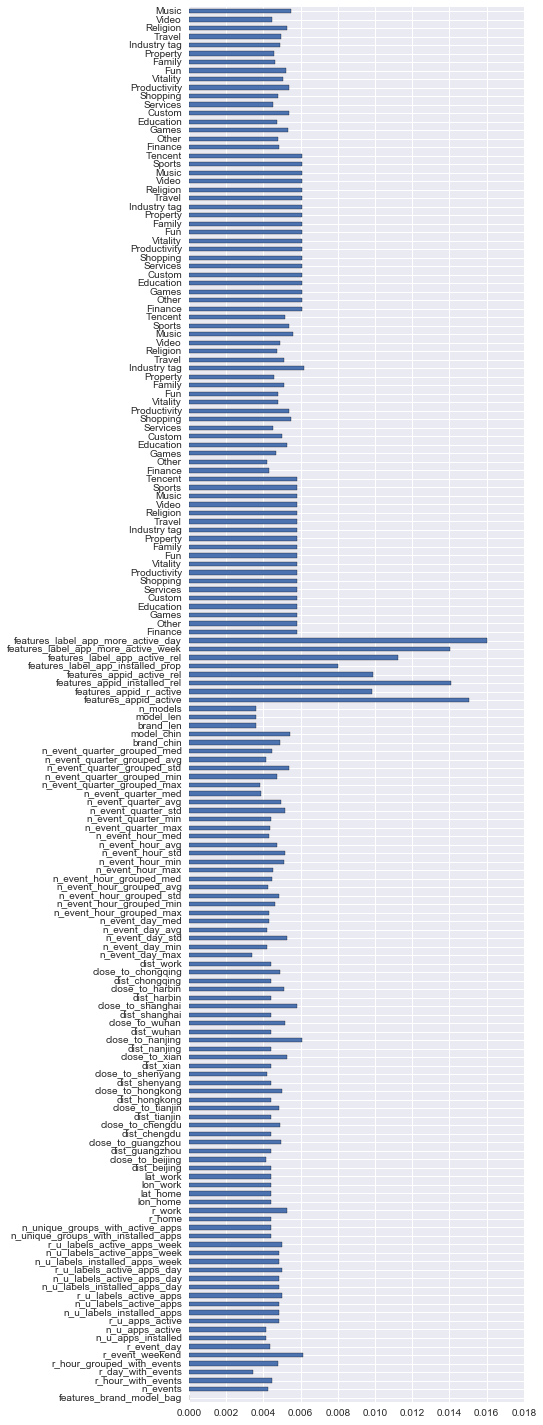

In [127]:
(a.scores-basescore).plot(kind='barh', figsize=(6,25))

### Add groups of features based on feature selection

In [1]:
feat_nr_new = feat_crit[feat_crit.chi2_score>0.01].feat_nr

NameError: name 'feat_crit' is not defined

In [ ]:
feature_files = ['features_events_totals.csv',
                 'features_appid_totals.csv',
                 'features_label_app_count.csv',
                 'features_group_app_count.csv',
                 'features_geo.csv',
                 'features_events_per_day.csv',
                 'features_events_per_hour_grouped.csv',
                 'features_events_per_hour.csv',
                 'features_events_per_quarter.csv',
                 'features_events_per_quarter_grouped.csv',
                 'features_brand_model_bag',
                 'features_brand_bag',
                 'features_brand_model.csv',
                 'features_appid_installed',
                 'features_appid_active',
                 'features_appid_r_active',
                 'features_appid_installed_active',
                 'features_appid_installed_rel',
                 'features_appid_active_rel',
                 'features_label_app_installed',
                 'features_label_app_installed_prop',
                 'features_label_app_active_rel',
                 'features_label_app_more_active_week',
                 'features_label_app_more_active_day',
                 'features_group_app_installed_count.csv',
                 'features_group_app_installed_prop.csv',
                 'features_group_app_active_count.csv',
                 'features_group_app_active_prop.csv',
                 'features_group_app_active_rel.csv']

In [ ]:
X_all = hstack([Xtrain, [open_feature_file(f) for f in feature_files_e]],format='csr')

In [ ]:
Xtrain_new = X_all[:, feat_nr_new]

In [28]:
X_train_new, X_val_new = Xtrain_new[train_cv.sample_nr, :], Xtrain_new[test_cv.sample_nr, :]

logloss val 2.24984462145


In [ ]:
newscore = score_nn(X_train, X_val, y_train, y_val, params)
print('Base score: {:.5f}'.format(basescore))
print('New score: {:.5f}'.format(newscore))

## Create test score

In [ ]:
# evaluate the model
pred_test = model.predict_generator(generator=batch_generatorp(Xtest, 32, False), val_samples=Xtest.shape[0])
pred = pd.DataFrame(pred_test, index = gatest['device_id'], columns=targetencoder.classes_)

In [ ]:
kag = KaggleResult(pred.values, pred.index.values, cv_score=cv_score, description='NN Model 1', subdir=sub_dir)

In [ ]:
if kag.validate():
    kag.upload()
print kag.lb_score


## Development

In [14]:
feature_files_e = ['features_events_totals.csv',
                 'features_appid_totals.csv',
                 'features_label_app_count.csv',
                 'features_group_app_count.csv',
                 'features_geo.csv',
                 'features_events_per_day.csv',
                 'features_events_per_hour_grouped.csv',
                 'features_events_per_hour.csv',
                 'features_events_per_quarter.csv',
                 'features_events_per_quarter_grouped.csv',
                 'features_brand_model.csv',
                 'features_appid_active',
                 'features_appid_r_active',
                 'features_appid_installed_active',
                 'features_appid_installed_rel',
                 'features_appid_active_rel',
                 'features_label_app_installed_prop',
                 'features_label_app_active_rel',
                 'features_label_app_more_active_week',
                 'features_label_app_more_active_day',
                 'features_group_app_installed_count.csv',
                 'features_group_app_installed_prop.csv',
                 'features_group_app_active_count.csv',
                 'features_group_app_active_prop.csv',
                 'features_group_app_active_rel.csv']


In [15]:
feat_params_files = {'extra_feat': hp.randint('extra_feat', len(feature_files))}

In [19]:
def f_nn_files(feat_params_files):
               
    params = {'optimizer': 'adamax',
          'batch_size': 400,
          'n_epoch': 15,
         'layer_1': {'on1': True,
                     'units1': 221,
                     'activation1': 'tanh',
                     'dropout1': 0.84},
         'layer_2': {'on2': True,
                    'units2': 232,
                    'activation2': 'relu',
                    'dropout2': 0.23},
          'layer_3': {'on3': False,
                     'units3': 12,
                     'activation3': 'sigmoid',
                     'dropout3': 0.2}
          }
    global counter
    global times
    
    Xtrain_l = hstack([Xtrain, open_feature_file(feature_files_e[feat_params_files['extra_feat']])],
                      format='csr')
    
    X_train, X_val, y_train, y_val = train_test_split(Xtrain_l, dummy_y, stratify=y,
                                                  test_size=0.1, random_state=rs)
    
    a = time.time()
    
    # create model
    print ('Params testing %d: %s' % (counter, feature_files_e[counter]))
    print('# Features: {}'.format(X_train.shape[1]))
    
    counter += 1
    
    model = Sequential()
    model.add(Dense(params['layer_1']['units1'], 
                    input_dim=X_train.shape[1], 
                    init='normal', 
                    activation=params['layer_1']['activation1']))
    
    model.add(Dropout(params['layer_1']['dropout1']))
    
    if params['layer_2']['on2']:
        model.add(Dense(params['layer_2']['units2'], 
                        init='normal', 
                        activation=params['layer_2']['activation2']))
        #https://www.kaggle.com/poiss0nriot/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/run/328610
        #model.add(PReLU())
        model.add(Dropout(params['layer_2']['dropout2']))
    
    model.add(Dense(12, init='normal', activation='softmax'))    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])  #logloss
    
    fit=model.fit(X_train.todense(), y_train, nb_epoch = int(params['n_epoch']), batch_size=int(params['batch_size']),
                             validation_data=(X_val.todense(), y_val), verbose=2) 
    
    scores_val = model.predict_proba(X_val.todense(), batch_size = 128, verbose = 2)

    logloss = log_loss(y_val, scores_val)
    times.append(a-time.time())
                        
    print('Log_loss:', logloss, 'It took', a-time.time())
    print('Average time per eval:', sum(times)/counter)
    sys.stdout.flush() 
    return {'loss': logloss, 'status': STATUS_OK}


In [20]:
# define baseline model
feat_params = {'feat_sel_criteria': feat_crit.columns[2],
               'value_min': 0,
               'value_max': hp.uniform('value_max', 0.01, 0.5)
               }

# Between 5k and 30k features
# P: max between 0.01 and 0.5, min 0
# Chi2: min 10 and 40, max 99999999
# annova_score 1.1 and 4 , max 99999
# extra_trees: 0.0001, 0.000001, max 999999
# pearson_score: 0.003 and 0.01 max 0.13
# random_log_score, 0.001 and 0.05  max 1.1


def f_nn(feat_params):
               
    params = {'optimizer': 'adamax',
          'batch_size': 400,
          'n_epoch': 15,
         'layer_1': {'on1': True,
                     'units1': 221,
                     'activation1': 'tanh',
                     'dropout1': 0.84},
         'layer_2': {'on2': True,
                    'units2': 232,
                    'activation2': 'relu',
                    'dropout2': 0.23}
          }
    global counter
    global times
    
    X_train_l = select_feature(X_train, 
                               feat_crit, 
                               feat_params['feat_sel_criteria'], 
                               feat_params['value_min'], 
                               feat_params['value_max'])
    X_val_l = select_feature(X_val, 
                             feat_crit, 
                             feat_params['feat_sel_criteria'], 
                             feat_params['value_min'], 
                             feat_params['value_max'])
    
    a = time.time()
    
    # create model
    print ('Params testing %d: %s' % (counter, feat_params))
    print('# Features: {}'.format(X_train_l.shape[1]))
    counter += 1
    
    model = Sequential()
    model.add(Dense(params['layer_1']['units1'], 
                    input_dim=X_train_l.shape[1], 
                    init='normal', 
                    activation=params['layer_1']['activation1']))
    
    model.add(Dropout(params['layer_1']['dropout1']))
    
    if params['layer_2']['on2']:
        model.add(Dense(params['layer_2']['units2'], 
                        init='normal', 
                        activation=params['layer_2']['activation2']))
        #https://www.kaggle.com/poiss0nriot/talkingdata-mobile-user-demographics/bag-of-apps-keras-11-08-16-no-val/run/328610
        #model.add(PReLU())
        model.add(Dropout(params['layer_2']['dropout2']))
    
    model.add(Dense(12, init='normal', activation='softmax'))    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'], metrics=['accuracy'])  #logloss
    
    fit=model.fit(X_train_l.todense(), y_train, nb_epoch = int(params['n_epoch']), batch_size=int(params['batch_size']),
                             validation_data=(X_val_l.todense(), y_val), verbose=2) 
    
    scores_val = model.predict_proba(X_val_l.todense(), batch_size = 128, verbose = 2)

    logloss = log_loss(y_val, scores_val)
    times.append(a-time.time())
                        
    print('Log_loss:', logloss, 'It took', a-time.time())
    print('Average time per eval:', sum(times)/counter)
    sys.stdout.flush() 
    return {'loss': logloss, 'status': STATUS_OK}


In [ ]:
counter = 0
times = []
trials = Trials()
best = fmin(f_nn_files, feat_params_files, algo=tpe.suggest, max_evals=100, trials=trials)
print 'best: '
print best

Params testing 0: features_events_totals.csv
# Features: 21536
Train on 67179 samples, validate on 7466 samples
Epoch 1/15
41s - loss: 2.4088 - acc: 0.1417 - val_loss: 2.3405 - val_acc: 0.1757
Epoch 2/15
40s - loss: 2.3428 - acc: 0.1653 - val_loss: 2.3015 - val_acc: 0.1883
Epoch 3/15
